In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
# Define company name and date ranges

In [4]:
COMPANY_IDENTIFIER = ['EMA','EMM','EMT','EMF']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC',
       'C10-0000939-LIC'], dtype=object)

In [9]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [10]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000695-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-04-04

Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-04-04

Verifying download summaries for license C10-0000786-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-04-04

Verifying download summaries for license C10-0000939-LIC...
Earliest download summary: 2021-10-01
Latest download summary: 2022-04-04

[SUCCESS] All download summaries look good!


In [11]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [12]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC']

In [ ]:
#license_numbers = ['402R-00808']

In [ ]:
#for BUD only
#license_numbers = ['C9-0000464-LIC',
# 'C9-0000467-LIC',
# 'C9-0000399-LIC']

In [ ]:
# run this if only has 1 license, or only want 1 license
#license_numbers = [license_numbers[0]]
#license_numbers

# License check

In [80]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


In [13]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]


In [14]:
retial_license_check_df

,license_number,license_category,is_current,license_status,license_check
0,C10-0000695-LIC,Retailer,True,Active,YES
1,C10-0000774-LIC,Retailer,True,Active,YES
2,C10-0000786-LIC,Retailer,True,Active,YES
3,C10-0000939-LIC,Retailer,True,Active,YES


## Pull data

In [15]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [16]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC',
       'C10-0000939-LIC'], dtype=object)

In [17]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000786-LIC', 'C10-0000695-LIC', 'C10-0000774-LIC',
       'C10-0000939-LIC'], dtype=object)

In [18]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC',
       'C10-0000695-LIC'], dtype=object)

## Unknown transfer packages

In [19]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [20]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[FAILURE] Found a total of 42 unknown transfer packages


42

## Receiver wholesale price coverage

In [21]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [22]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(23079, 32)

In [23]:
company_incoming_transfer_packages_dataframe.shape

(23884, 32)

In [24]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


97.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [25]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [26]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [27]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000786-LIC', 'C10-0000695-LIC', 'C10-0000774-LIC',
       'C10-0000939-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [28]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [29]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 501335


In [30]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


,sales_month,receipt_number
sales_month,,


## Receipts missing metrc_sales_transactions

In [31]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [32]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 232832


In [33]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

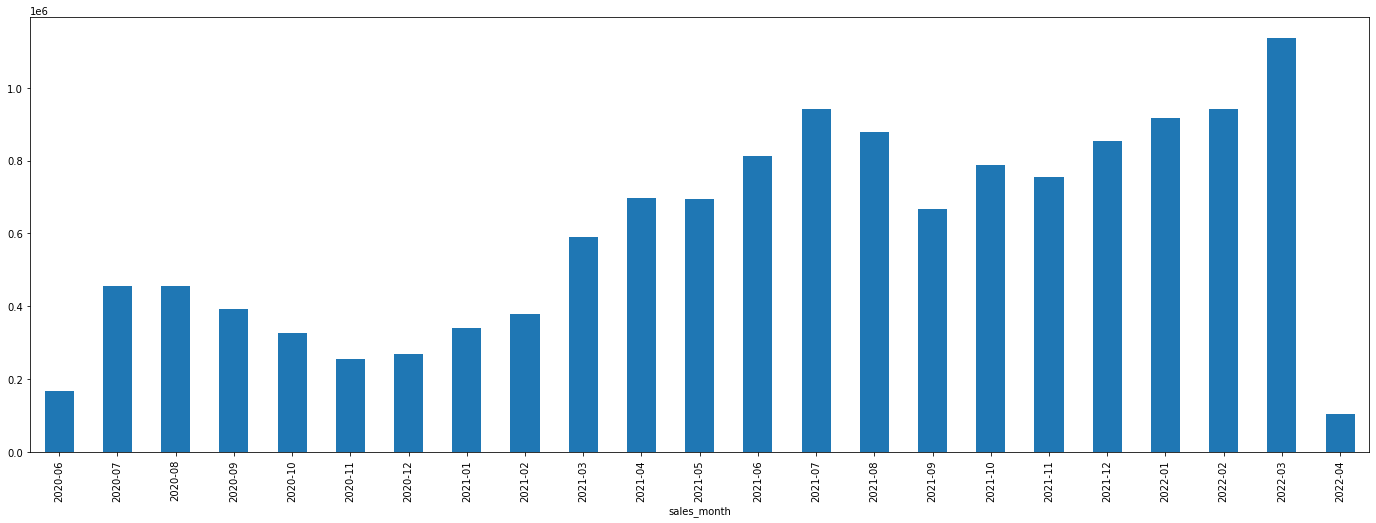

In [34]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# For Embarc only

In [35]:
if COMPANY_IDENTIFIER == ['EMA','EMM','EMT','EMF']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_ema = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_incoming_transfer_packages_dataframe_emm = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_incoming_transfer_packages_dataframe_emt = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_incoming_transfer_packages_dataframe_emf = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_ema = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000774-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emm = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000786-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emt = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000695-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emf = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000939-LIC']
    #inventory
    company_inventory_packages_dataframe_ema = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_inventory_packages_dataframe_emm = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_inventory_packages_dataframe_emt = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    company_inventory_packages_dataframe_emf = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000939-LIC']
    

# For BUD only

In [ ]:
# if COMPANY_IDENTIFIER == ['BUD']:
#     #incoming transfer
#     company_incoming_transfer_packages_dataframe_sac = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000399-LIC']
#     company_incoming_transfer_packages_dataframe_fresno = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000467-LIC']
#     company_incoming_transfer_packages_dataframe_la = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000464-LIC']
#     #sales & receipt
#     deduped_sales_receipts_with_transactions_dataframe_sac = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000399-LIC']
#     deduped_sales_receipts_with_transactions_dataframe_fresno = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000467-LIC']
#     deduped_sales_receipts_with_transactions_dataframe_la = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000464-LIC']

    
#     #inventory
#     company_inventory_packages_dataframe_sac = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000399-LIC']
#     company_inventory_packages_dataframe_fresno = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000467-LIC']
#     company_inventory_packages_dataframe_la = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000464-LIC']

    

# Vendor churn

In [36]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2021-12-01','2022-01-01','2022-02-01','2022-03-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [37]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_windown,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(vc_windown).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


## embarc only

In [38]:
churn_ema,vc_matrix_ema = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm,vc_matrix_emm = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt,vc_matrix_emt = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emf,vc_matrix_emf = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emf,['C10-0000939-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



In [40]:
churn_ema

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


## BUD only

In [ ]:
# churn_sac,vc_matrix_sac = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_sac,['C9-0000399-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
# churn_fresno,vc_matrix_fresno = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_fresno,['C9-0000467-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
# churn_la,vc_matrix_la = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_la,['C9-0000464-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)




In [ ]:
# ax = churn_la['%_inactive'].plot(marker = 'o',figsize = (12,8))
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
# ax = plt.title('Rolling 4m vendor churn')

## Others

In [ ]:
license_numbers

In [ ]:
churn,vc_matrix = calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)

In [ ]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')

# Receiver wholesale price outlier check

In [41]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort.dropna()["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [42]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: inf from package ID: 22088845
min per unit incoming: 0.00014705882352941178 from package ID: 17214454



In [43]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,22088845,inf
1,19579881,100.00
2,5668478,96.00
3,5668479,96.00
4,5668480,96.00
5,5668481,96.00
6,5668482,96.00
7,5668483,96.00
8,5668477,96.00
9,14295382,95.25


In [44]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
23520,20133351,0.000156
23521,20133355,0.000156
23522,20137429,0.000156
23523,20133358,0.000156
23524,17214454,0.000147


In [45]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
2201,INCOMING_FROM_VENDOR,C10-0000695-LIC,0003065290,2022-02-09,2022-02-10 21:02:38+00:00,Wholesale,C11-0000118-LIC,SECURE HAULING LLC,C10-0000695-LIC,EMBARC TAHOE LLC,Wholesale Manifest,Wholesale,22088845,1A40603000038C5000093515,transfer,1A4060300020919000000350,"r2.c1.21.01, r7.c2.21.01, r8.c2.21.01",Shipped,False,False,Vape Cartridge (weight - each),Friendly Farms - Horchata - 0.5g Cured Resin C...,passed,200.0,0.0,Each,NaN,NaN,None,NaN,0.5,Grams,inf


# COGS analysis

In [46]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')

    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage','total_count']]
    
    return df_summary_simp,df_cogs_average_product




In [ ]:
# def cogs_analysis_uom(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
#     df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
#     # set frequency
#     if freq == 'monthly':
#         df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
#     elif freq == 'weekly':
#         df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
#         df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
#     # total # of trxns
#     s_total_count = df_sales.groupby('date')['tx_total_price'].count()
#     df_total_count = pd.Series(s_total_count).to_frame()
#     df_total_count = df_total_count.reset_index()
#     df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
#     # revenue
#     s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
#     df_revenue = pd.Series(s_revenue).to_frame()
#     df_revenue = df_revenue.reset_index()
#     df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

#     df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
#     # per unit price by package id
#     df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
#     average_incoming_package_id = df_in_price.groupby(['package_id','shipped_unit_of_measure'])['per_unit_incoming'].mean()
#     df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
#     df_avg_incoming_price = df_avg_incoming_price.reset_index()
#     # per unit price by product name
#     average_incoming_product = df_in_price.groupby(['product_name','shipped_unit_of_measure'])['per_unit_incoming'].mean()
#     df_avg_product = pd.Series(average_incoming_product).to_frame()
#     df_avg_product = df_avg_product.reset_index()
#     df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

#     # merge with (cogs by package id)
#     df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on=['tx_package_id','tx_unit_of_measure'], right_on=['package_id','shipped_unit_of_measure'], how='left')
#     df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
#     df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
#     df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

#     # sum cogs by package id
#     s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
#     df_cogs_id = pd.Series(s_cogs).to_frame()
#     df_cogs_id = df_cogs_id.reset_index()
#     # count # of trxn by package id
#     s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
#     df_cogs_count = pd.Series(s_cogs_count).to_frame()
#     df_cogs_count = df_cogs_count.reset_index()
#     df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
#     # merge with (cogs by product name)
#     df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left')
#     df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
#     df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
#     df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
#     # sum cogs filldown by product name
#     product_sum = df_cogs_product.groupby('date')['total_product'].sum()
#     df_product_sum = pd.Series(product_sum).to_frame()
#     df_product_sum = df_product_sum.reset_index()
#     df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
#     # count # of trxn filldown by product name
#     product_count = df_cogs_product.groupby('date')['total_product'].count()
#     df_product_count = pd.Series(product_count).to_frame()
#     df_product_count = df_product_count.reset_index()
#     df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
#     df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
#     # prepare summary
#     df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
#     df_summary = pd.merge(df_summary, df_cogs_id, how='left')
#     df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
#     df_summary['product_count'] = df_summary['product_count'].fillna(0)
#     # total cogs = by product id cogs + by product name cogs
#     df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
#     df_summary = pd.merge(df_summary, df_cogs_count)
#     df_summary = pd.merge(df_summary, df_total_count)
#     # total count = by package id count + by product count
#     df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
#     df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
#     df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
#     df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
#     df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage','total_count']]
    
#     return df_summary_simp,df_avg_product




In [48]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

## For Others

In [ ]:
df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_sales,'monthly')
#tax treatment
df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
# past quarter pre tax
df_summary_simp['gm_past_quarter'] = df_summary_simp[['margin_%']].rolling(3).mean().values
df_summary_simp['gm_past_2quarters'] = df_summary_simp[['margin_%']].rolling(6).mean().values
df_summary_simp['gm_past_3quarters'] = df_summary_simp[['margin_%']].rolling(9).mean().values
df_summary_simp['sum_cogs_past_3months'] = df_summary_simp[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()
df_summary_simp.index = df_summary_simp.date 


In [ ]:
#df_summary_simp['coverage'].mean()

In [ ]:
df_summary_simp

# Revenue change vs state

In [52]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    else:
        return 10
    

### for CA

In [53]:
def calculate_quarterly_sum_gmv_ca(cogs_analysis_df):
    #2020
    sum_gmv_q1_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-01')&(cogs_analysis_df['date']<= '2020-03')]['revenue'].sum()
    sum_gmv_q2_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-04')&(cogs_analysis_df['date']<= '2020-06')]['revenue'].sum()
    sum_gmv_q3_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-07')&(cogs_analysis_df['date']<= '2020-09')]['revenue'].sum()
    sum_gmv_q4_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-10')&(cogs_analysis_df['date']<= '2020-12')]['revenue'].sum()
    #2021
    sum_gmv_q1_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-01')&(cogs_analysis_df['date']<= '2021-03')]['revenue'].sum()
    sum_gmv_q2_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-04')&(cogs_analysis_df['date']<= '2021-06')]['revenue'].sum()
    sum_gmv_q3_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-07')&(cogs_analysis_df['date']<= '2021-09')]['revenue'].sum()
    sum_gmv_q4_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-10')&(cogs_analysis_df['date']<= '2021-12')]['revenue'].sum()
    gmv_df = pd.DataFrame([sum_gmv_q1_2020,sum_gmv_q2_2020,sum_gmv_q3_2020,sum_gmv_q4_2020,\
                  sum_gmv_q1_2021,sum_gmv_q2_2021,sum_gmv_q3_2021,sum_gmv_q4_2021])
    gmv_df.columns = ['sum_gmv']
    gmv_df['sum_gmv_change'] = gmv_df['sum_gmv'].pct_change().values
    gmv_df['sum_gmv_change_ca'] = [numpy.nan,numpy.nan,numpy.nan,0.17,-0.05,0.02,-0.11,0]
    gmv_df['weight'] = [numpy.nan,numpy.nan,numpy.nan,0.04,0.28,0.52,0.76,1]
    gmv_df['variance'] = gmv_df['sum_gmv_change'] - gmv_df['sum_gmv_change_ca']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    gmv_df.index = ['2020Q1','2020Q2','2020Q3','2020Q4','2021Q1','2021Q2','2021Q3','2021Q4']
    #gmv_df = gmv_df.dropna()
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_ca(df_summary_simp)
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR MA

In [ ]:
def calculate_quarterly_sum_gmv_ma(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
    gmv_df['sum_gmv_change_ma'] = [-0.07,0.01,-0.07,0.09,-0.11,0.02]
    gmv_df['weight'] = [0.6,0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_ma(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR CO

In [ ]:
def calculate_quarterly_sum_gmv_co(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-01')&(cogs_analysis_df['date'] <= '2022-01')][['revenue_change']]
    gmv_df['sum_gmv_change_co'] = [0.01,-0.11,0.23,-0.01,-0.06,-0.03,0.1,-0.06,-0.05,-0.03,-0.11,0.06,0.09]
    gmv_df['weight'] = [0.04,0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_co']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_co(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR MI

In [ ]:
def calculate_quarterly_sum_gmv_mi(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-01')&(cogs_analysis_df['date'] <= '2022-01')][['revenue_change']]
    gmv_df['sum_gmv_change_mi'] = [-0.06,0.36,0.01,-0.07,-0.02,0.12,-0.11,-0.04,-0.01,-0.1,0.06,-0.11]
    gmv_df['weight'] = [0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_mi']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_mi(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

# embarc only

### ema

In [49]:
df_inventory_ema = company_inventory_packages_dataframe_ema
df_sales_ema = deduped_sales_receipts_with_transactions_dataframe_ema

In [50]:
df_summary_simp_ema,_ = cogs_analysis(df_in,df_sales_ema,'monthly')
#tax treatment
df_summary_simp_ema['revenue_after_tax'] = df_summary_simp_ema['revenue'] * 1.15
df_summary_simp_ema['cogs_after_tax'] = df_summary_simp_ema['cogs'] * 1.27
df_summary_simp_ema['margin_$_after_tax'] = df_summary_simp_ema['revenue_after_tax'] - df_summary_simp_ema['cogs_after_tax']
df_summary_simp_ema['margin_%_after_tax'] = df_summary_simp_ema['margin_$_after_tax'] / df_summary_simp_ema['revenue_after_tax']
# past quarter pre tax
df_summary_simp_ema['gm_past_quarter'] = df_summary_simp_ema[['margin_%']].rolling(3).mean().values
df_summary_simp_ema['gm_past_2quarters'] = df_summary_simp_ema[['margin_%']].rolling(6).mean().values
df_summary_simp_ema['gm_past_3quarters'] = df_summary_simp_ema[['margin_%']].rolling(9).mean().values
df_summary_simp_ema['sum_cogs_past_3months'] = df_summary_simp_ema[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_ema['gm_past_quarter_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_ema['gm_past_2quarters_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_ema['gm_past_3quarters_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_ema['revenue_change'] = df_summary_simp_ema['revenue'].pct_change()
df_summary_simp_ema.index = df_summary_simp_ema.date 





In [51]:
df_summary_simp_ema

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,19859.61,9170.234467,10689.375533,0.538247,1401.0,0.0,1401,1.000000,1401,22838.5515,11646.197773,11192.353727,0.490064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,2021-02,80744.84,32263.279067,48481.560933,0.600429,3796.0,0.0,3796,1.000000,3796,92856.5660,40974.364415,51882.201585,0.558735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.065782
2021-03,2021-03,134043.73,53829.047647,80214.682353,0.598422,5046.0,0.0,5046,1.000000,5046,154150.2895,68362.890511,85787.398989,0.556518,0.579033,NaN,NaN,95262.561180,0.535106,NaN,NaN,0.660090
2021-04,2021-04,175008.51,69795.277090,105213.232910,0.601189,7607.0,0.0,7607,1.000000,7607,201259.7865,88640.001904,112619.784596,0.559574,0.600013,NaN,NaN,155887.603803,0.558276,NaN,NaN,0.305608
2021-05,2021-05,140819.75,53598.972213,87220.777787,0.619379,5192.0,0.0,5192,0.999038,5197,161942.7125,68070.694710,93872.017790,0.579662,0.606330,NaN,NaN,177223.296949,0.565251,NaN,NaN,-0.195355
2021-06,2021-06,193762.33,73906.045970,119856.284030,0.618574,7625.0,0.0,7625,0.985269,7739,222826.6795,93860.678382,128966.001118,0.578773,0.613047,0.596040,NaN,197300.295272,0.572670,0.553888,NaN,0.375960
2021-07,2021-07,224052.69,88023.548698,136029.141302,0.607130,9436.0,8.0,9428,0.998836,9447,257660.5935,111789.906847,145870.686653,0.566135,0.615028,0.607520,NaN,215528.566881,0.574857,0.566566,NaN,0.156327
2021-08,2021-08,245301.61,96114.298364,149187.311636,0.608179,9140.0,321.0,8819,0.997817,9160,282096.8515,122065.158923,160031.692577,0.567293,0.611294,0.608812,NaN,258043.893033,0.570734,0.567993,NaN,0.094839
2021-09,2021-09,218350.18,85725.710270,132624.469730,0.607393,8060.0,313.0,7747,0.986657,8169,251102.7070,108871.652043,142231.054957,0.566426,0.607568,0.610307,0.599882,269863.557333,0.566618,0.569644,0.558131,-0.109871


In [54]:
ema_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_ema)
ema_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,234648.18,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,509590.59,1.171722,0.02,0.52,1.151722,10,5.2
2021Q3,687704.48,0.349524,-0.11,0.76,0.459524,10,7.6
2021Q4,778746.05,0.132385,0.00,1.00,0.132385,10,10.0


In [55]:
round(ema_revenue_vs_state.dropna()['total'].sum(),2)

22.8

### emm

In [56]:
df_inventory_emm = company_inventory_packages_dataframe_emm
df_sales_emm = deduped_sales_receipts_with_transactions_dataframe_emm

In [57]:
df_summary_simp_emm,_ = cogs_analysis(df_in,df_sales_emm,'monthly')
#tax treatment
df_summary_simp_emm['revenue_after_tax'] = df_summary_simp_emm['revenue'] * 1.15
df_summary_simp_emm['cogs_after_tax'] = df_summary_simp_emm['cogs'] * 1.27
df_summary_simp_emm['margin_$_after_tax'] = df_summary_simp_emm['revenue_after_tax'] - df_summary_simp_emm['cogs_after_tax']
df_summary_simp_emm['margin_%_after_tax'] = df_summary_simp_emm['margin_$_after_tax'] / df_summary_simp_emm['revenue_after_tax']
# past quarter pre tax
df_summary_simp_emm['gm_past_quarter'] = df_summary_simp_emm[['margin_%']].rolling(3).mean().values
df_summary_simp_emm['gm_past_2quarters'] = df_summary_simp_emm[['margin_%']].rolling(6).mean().values
df_summary_simp_emm['gm_past_3quarters'] = df_summary_simp_emm[['margin_%']].rolling(9).mean().values
df_summary_simp_emm['sum_cogs_past_3months'] = df_summary_simp_emm[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_emm['gm_past_quarter_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_emm['gm_past_2quarters_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_emm['gm_past_3quarters_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_emm['revenue_change'] = df_summary_simp_emm['revenue'].pct_change()
df_summary_simp_emm.index = df_summary_simp_emm.date 




In [58]:
df_summary_simp_emm

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,
2021-03,2021-03,101169.45,47488.319560,53681.130440,0.530606,4474.0,0.0,4474,1.000000,4474,116344.8675,60310.165841,56034.701659,0.481626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04,2021-04,258013.89,104777.059245,153236.830755,0.593909,9678.0,0.0,9678,1.000000,9678,296715.9735,133066.865242,163649.108258,0.551535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.550314
2021-05,2021-05,282162.28,110435.511133,171726.768867,0.608610,9616.0,1.0,9615,0.996270,9652,324486.6220,140253.099139,184233.522861,0.567769,0.577708,NaN,NaN,262700.889939,0.533643,NaN,NaN,0.093593
2021-06,2021-06,292814.20,115306.966886,177507.233114,0.606211,9970.0,0.0,9970,0.994117,10029,336736.3300,146439.847945,190296.482055,0.565120,0.602910,NaN,NaN,330519.537265,0.561475,NaN,NaN,0.037751
2021-07,2021-07,326658.60,131105.311936,195553.288064,0.598647,12007.0,0.0,12007,0.996432,12050,375657.3900,166503.746158,209153.643842,0.556767,0.604489,NaN,NaN,356847.789955,0.563219,NaN,NaN,0.115583
2021-08,2021-08,344119.57,135400.150012,208719.419988,0.606532,11814.0,0.0,11814,0.996289,11858,395737.5055,171958.190515,223779.314985,0.565474,0.603797,0.590753,NaN,381812.428833,0.562454,0.548048,NaN,0.053453
2021-09,2021-09,315679.80,129307.558306,186372.241694,0.590384,10768.0,0.0,10768,0.989433,10883,363031.7700,164220.599048,198811.170952,0.547641,0.598521,0.600716,NaN,395813.020253,0.556627,0.559051,NaN,-0.082645
2021-10,2021-10,278104.29,111964.990222,166139.299778,0.597399,9749.0,0.0,9749,0.986541,9882,319819.9335,142195.537582,177624.395918,0.555389,0.598105,0.601297,NaN,376672.698540,0.556168,0.559693,NaN,-0.119030
2021-11,2021-11,285601.18,112748.547427,172852.632573,0.605224,9356.0,0.0,9356,0.977026,9576,328441.3570,143190.655232,185250.701768,0.564030,0.597669,0.600733,0.593058,354021.095955,0.555687,0.559070,0.550595,0.026957


In [59]:
emm_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emm)
emm_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,101169.45,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,832990.37,7.233616,0.02,0.52,7.213616,10,5.2
2021Q3,986457.97,0.184237,-0.11,0.76,0.294237,10,7.6
2021Q4,887419.14,-0.100398,0.00,1.00,-0.100398,-5,-5.0


In [60]:
round(emm_revenue_vs_state.dropna()['total'].sum(),2)

7.8

### emt

In [61]:
df_inventory_emt = company_inventory_packages_dataframe_emt
df_sales_emt = deduped_sales_receipts_with_transactions_dataframe_emt

In [62]:
df_summary_simp_emt,_ = cogs_analysis(df_in,df_sales_emt,'monthly')
#tax treatment
df_summary_simp_emt['revenue_after_tax'] = df_summary_simp_emt['revenue'] * 1.15
df_summary_simp_emt['cogs_after_tax'] = df_summary_simp_emt['cogs'] * 1.27
df_summary_simp_emt['margin_$_after_tax'] = df_summary_simp_emt['revenue_after_tax'] - df_summary_simp_emt['cogs_after_tax']
df_summary_simp_emt['margin_%_after_tax'] = df_summary_simp_emt['margin_$_after_tax'] / df_summary_simp_emt['revenue_after_tax']
# past quarter pre tax
df_summary_simp_emt['gm_past_quarter'] = df_summary_simp_emt[['margin_%']].rolling(3).mean().values
df_summary_simp_emt['gm_past_2quarters'] = df_summary_simp_emt[['margin_%']].rolling(6).mean().values
df_summary_simp_emt['gm_past_3quarters'] = df_summary_simp_emt[['margin_%']].rolling(9).mean().values
df_summary_simp_emt['sum_cogs_past_3months'] = df_summary_simp_emt[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_emt['gm_past_quarter_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_emt['gm_past_2quarters_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_emt['gm_past_3quarters_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_emt['revenue_change'] = df_summary_simp_emt['revenue'].pct_change()
df_summary_simp_emt.index = df_summary_simp_emt.date 


In [63]:
df_summary_simp_emt

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,
2020-06,2020-06,168464.30,61034.192262,107430.107738,0.637703,5751.0,0.0,5751,1.000000,5751,193733.9450,77513.424173,116220.520827,0.599898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07,2020-07,454664.49,173447.195669,281217.294331,0.618516,13969.0,0.0,13969,1.000000,13969,522864.1635,220277.938500,302586.225000,0.578709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.698877
2020-08,2020-08,456226.13,167489.602869,288736.527131,0.632880,14171.0,0.0,14171,1.000000,14171,524660.0495,212711.795644,311948.253856,0.594572,0.629700,NaN,NaN,401970.990801,0.591060,NaN,NaN,0.003435
2020-09,2020-09,393929.64,146209.738615,247719.901385,0.628843,12322.0,0.0,12322,1.000000,12322,453019.0860,185686.368041,267332.717959,0.590114,0.626746,NaN,NaN,487146.537154,0.587798,NaN,NaN,-0.136547
2020-10,2020-10,325595.48,124824.219498,200771.260502,0.616628,11045.0,0.0,11045,1.000000,11045,374434.8020,158526.758763,215908.043237,0.576624,0.626117,NaN,NaN,438523.560983,0.587103,NaN,NaN,-0.173468
2020-11,2020-11,255188.40,97070.861693,158117.538307,0.619611,7956.0,0.0,7956,1.000000,7956,293466.6600,123279.994350,170186.665650,0.579918,0.621694,0.625697,NaN,368104.819806,0.582219,0.586639,NaN,-0.216241
2020-12,2020-12,270067.64,102723.247042,167344.392958,0.619639,8397.0,4.0,8393,0.990096,8481,310577.7860,130458.523743,180119.262257,0.579949,0.618626,0.622686,NaN,324618.328233,0.578830,0.583314,NaN,0.058307
2021-01,2021-01,320052.85,114302.292478,205750.557522,0.642864,10445.0,26.0,10419,0.991645,10533,368060.7775,145163.911447,222896.866053,0.605598,0.627371,0.626744,NaN,314096.401213,0.588488,0.587796,NaN,0.185084
2021-02,2021-02,298615.28,112772.246149,185843.033851,0.622349,10785.0,0.0,10785,0.999629,10789,343407.5720,143220.752609,200186.819391,0.582942,0.628284,0.624989,0.626559,329797.785669,0.589496,0.585857,0.587592,-0.066981


In [64]:
emt_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emt)
emt_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,168464.30,NaN,NaN,NaN,NaN,10,NaN
2020Q3,1304820.26,6.745381,NaN,NaN,NaN,10,NaN
2020Q4,850851.52,-0.347917,0.17,0.04,-0.517917,-5,-0.2
2021Q1,974143.51,0.144904,-0.05,0.28,0.194904,10,2.8
2021Q2,862586.35,-0.114518,0.02,0.52,-0.134518,-5,-2.6
2021Q3,812894.33,-0.057608,-0.11,0.76,0.052392,10,7.6
2021Q4,730129.66,-0.101815,0.00,1.00,-0.101815,-5,-5.0


In [65]:
round(emt_revenue_vs_state.dropna()['total'].sum(),2)

2.6

### EMF

In [66]:
df_inventory_emf = company_inventory_packages_dataframe_emf
df_sales_emf = deduped_sales_receipts_with_transactions_dataframe_emf

In [67]:
df_summary_simp_emf,_ = cogs_analysis(df_in,df_sales_emf,'monthly')
#tax treatment
df_summary_simp_emf['revenue_after_tax'] = df_summary_simp_emf['revenue'] * 1.15
df_summary_simp_emf['cogs_after_tax'] = df_summary_simp_emf['cogs'] * 1.27
df_summary_simp_emf['margin_$_after_tax'] = df_summary_simp_emf['revenue_after_tax'] - df_summary_simp_emf['cogs_after_tax']
df_summary_simp_emf['margin_%_after_tax'] = df_summary_simp_emf['margin_$_after_tax'] / df_summary_simp_emf['revenue_after_tax']
# past quarter pre tax
df_summary_simp_emf['gm_past_quarter'] = df_summary_simp_emf[['margin_%']].rolling(3).mean().values
df_summary_simp_emf['gm_past_2quarters'] = df_summary_simp_emf[['margin_%']].rolling(6).mean().values
df_summary_simp_emf['gm_past_3quarters'] = df_summary_simp_emf[['margin_%']].rolling(9).mean().values
df_summary_simp_emf['sum_cogs_past_3months'] = df_summary_simp_emf[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_emf['gm_past_quarter_after_tax'] = df_summary_simp_emf[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_emf['gm_past_2quarters_after_tax'] = df_summary_simp_emf[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_emf['gm_past_3quarters_after_tax'] = df_summary_simp_emf[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_emf['revenue_change'] = df_summary_simp_emf['revenue'].pct_change()
df_summary_simp_emf.index = df_summary_simp_emf.date 


In [68]:
df_summary_simp_emf

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,
2022-02,2022-02,97575.00,41093.654524,56481.345476,0.578851,4371,29,4342,0.992281,4405,112211.250,52188.941245,60022.308755,0.534905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03,2022-03,198325.34,76212.643381,122112.696619,0.615719,7916,114,7802,0.986417,8025,228074.141,96790.057094,131284.083906,0.575620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032543
2022-04,2022-04,21459.88,8902.037167,12557.842833,0.585178,931,12,919,0.989373,941,24678.862,11305.587202,13373.274798,0.541892,0.593249,NaN,NaN,126208.335071,0.550806,NaN,NaN,-0.891795


In [69]:
emf_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emf)
emf_revenue_vs_state

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.0,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.0,NaN,0.17,0.04,NaN,10,0.4
2021Q1,0.0,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,0.0,NaN,0.02,0.52,NaN,10,5.2
2021Q3,0.0,NaN,-0.11,0.76,NaN,10,7.6
2021Q4,0.0,NaN,0.00,1.00,NaN,10,10.0


In [70]:
round(emf_revenue_vs_state.dropna()['total'].sum(),2)

0.0

## BUD only

### sac

In [ ]:
df_inventory_sac = company_inventory_packages_dataframe_sac
df_sales_sac = deduped_sales_receipts_with_transactions_dataframe_sac

In [ ]:
df_summary_simp_sac,_ = cogs_analysis(df_in,df_sales_sac,'monthly')
#tax treatment
df_summary_simp_sac['revenue_after_tax'] = df_summary_simp_sac['revenue'] * 1.15
df_summary_simp_sac['cogs_after_tax'] = df_summary_simp_sac['cogs'] * 1.27
df_summary_simp_sac['margin_$_after_tax'] = df_summary_simp_sac['revenue_after_tax'] - df_summary_simp_sac['cogs_after_tax']
df_summary_simp_sac['margin_%_after_tax'] = df_summary_simp_sac['margin_$_after_tax'] / df_summary_simp_sac['revenue_after_tax']
# past quarter pre tax
df_summary_simp_sac['gm_past_quarter'] = df_summary_simp_sac[['margin_%']].rolling(3).mean().values
df_summary_simp_sac['gm_past_2quarters'] = df_summary_simp_sac[['margin_%']].rolling(6).mean().values
df_summary_simp_sac['gm_past_3quarters'] = df_summary_simp_sac[['margin_%']].rolling(9).mean().values
df_summary_simp_sac['sum_cogs_past_3months'] = df_summary_simp_sac[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_sac['gm_past_quarter_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_sac['gm_past_2quarters_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_sac['gm_past_3quarters_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_sac['revenue_change'] = df_summary_simp_sac['revenue'].pct_change()
df_summary_simp_sac.index = df_summary_simp_sac.date 



In [ ]:
df_summary_simp_sac

In [ ]:
sac_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_sac)
round(sac_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
sac_revenue_vs_state

### fresno

In [ ]:
df_inventory_fresno = company_inventory_packages_dataframe_fresno
df_sales_fresno = deduped_sales_receipts_with_transactions_dataframe_fresno

In [ ]:
df_summary_simp_fresno,_ = cogs_analysis(df_in,df_sales_fresno,'monthly')
#tax treatment
df_summary_simp_fresno['revenue_after_tax'] = df_summary_simp_fresno['revenue'] * 1.15
df_summary_simp_fresno['cogs_after_tax'] = df_summary_simp_fresno['cogs'] * 1.27
df_summary_simp_fresno['margin_$_after_tax'] = df_summary_simp_fresno['revenue_after_tax'] - df_summary_simp_fresno['cogs_after_tax']
df_summary_simp_fresno['margin_%_after_tax'] = df_summary_simp_fresno['margin_$_after_tax'] / df_summary_simp_fresno['revenue_after_tax']
# past quarter pre tax
df_summary_simp_fresno['gm_past_quarter'] = df_summary_simp_fresno[['margin_%']].rolling(3).mean().values
df_summary_simp_fresno['gm_past_2quarters'] = df_summary_simp_fresno[['margin_%']].rolling(6).mean().values
df_summary_simp_fresno['gm_past_3quarters'] = df_summary_simp_fresno[['margin_%']].rolling(9).mean().values
df_summary_simp_fresno['sum_cogs_past_3months'] = df_summary_simp_fresno[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_fresno['gm_past_quarter_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_fresno['gm_past_2quarters_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_fresno['gm_past_3quarters_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_fresno['revenue_change'] = df_summary_simp_fresno['revenue'].pct_change()
df_summary_simp_fresno.index = df_summary_simp_fresno.date 



In [ ]:
df_summary_simp_fresno

In [ ]:
fresno_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_fresno)
fresno_revenue_vs_state
round(fresno_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
fresno_revenue_vs_state

### LA

In [ ]:
df_inventory_la = company_inventory_packages_dataframe_la
df_sales_la = deduped_sales_receipts_with_transactions_dataframe_la

In [ ]:
df_summary_simp_la,_ = cogs_analysis(df_in,df_sales_la,'monthly')
#tax treatment
df_summary_simp_la['revenue_after_tax'] = df_summary_simp_la['revenue'] * 1.15
df_summary_simp_la['cogs_after_tax'] = df_summary_simp_la['cogs'] * 1.27
df_summary_simp_la['margin_$_after_tax'] = df_summary_simp_la['revenue_after_tax'] - df_summary_simp_la['cogs_after_tax']
df_summary_simp_la['margin_%_after_tax'] = df_summary_simp_la['margin_$_after_tax'] / df_summary_simp_la['revenue_after_tax']
# past quarter pre tax
df_summary_simp_la['gm_past_quarter'] = df_summary_simp_la[['margin_%']].rolling(3).mean().values
df_summary_simp_la['gm_past_2quarters'] = df_summary_simp_la[['margin_%']].rolling(6).mean().values
df_summary_simp_la['gm_past_3quarters'] = df_summary_simp_la[['margin_%']].rolling(9).mean().values
df_summary_simp_la['sum_cogs_past_3months'] = df_summary_simp_la[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_la['gm_past_quarter_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_la['gm_past_2quarters_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_la['gm_past_3quarters_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_la['revenue_change'] = df_summary_simp_la['revenue'].pct_change()
df_summary_simp_la.index = df_summary_simp_la.date 



In [ ]:
df_summary_simp_la

In [ ]:
la_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_la)
la_revenue_vs_state
round(la_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
la_revenue_vs_state

# Inventory

In [71]:
today = date.today()
today

datetime.date(2022, 4, 4)

In [72]:
COMPANY_IDENTIFIER

['EMA', 'EMM', 'EMT', 'EMF']

In [73]:
license_numbers

['C10-0000695-LIC', 'C10-0000774-LIC', 'C10-0000786-LIC', 'C10-0000939-LIC']

In [74]:
def calculate_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(['package_id'])['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(['product_name'])['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, left_on=['package_id'],right_on = ['package_id'], how='left')
    #left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left'
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, left_on=['product_name'],right_on = ['product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.27
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [total_inv_value_after_tax],
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','value_after_tax','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [191]:
def calculate_msrp_based_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")    
    # per unit msrp by package id
    df_msrp = sales_df[sales_df['tx_total_price'].notnull()]
    average_msrp_package_id = df_msrp.groupby('tx_package_id')['per_unit'].mean()
    df_avg_msrp_package_id = pd.Series(average_msrp_package_id).to_frame()
    df_avg_msrp_package_id = df_avg_msrp_package_id.reset_index()
    # per unit msrp by product name
    average_msrp_product = df_msrp.groupby('tx_product_name')['per_unit'].mean()
    df_avg_msrp_product = pd.Series(average_msrp_product).to_frame()
    df_avg_msrp_product = df_avg_msrp_product.reset_index()
    df_avg_msrp_product.rename(columns={'per_unit':'per_unit_product'}, inplace=True)
    
    #calculate inventory
    #merge with per unit msrp by package id
    df_inventory_package_id = pd.merge(inventory_df, df_avg_msrp_package_id, left_on=['package_id'],right_on = ['tx_package_id'], how='left')
    df_inventory_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    # merge with per unit msrp by product
    df_inv_null = df_inventory_package_id[df_inventory_package_id['per_unit'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_msrp_product, left_on=['product_name'],right_on = ['tx_product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    inventory_product_value = df_inv_product_price['total_price'].sum()
    
    df_inventory_package_id['total_price'] = df_inventory_package_id['quantity'] * df_inventory_package_id['per_unit']
    inventory_package_id_value = df_inventory_package_id['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_package_id_value
    total_inv_value_after_tax = total_inv_value * 1.15
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_package_id = df_inventory_package_id['per_unit'].count()
    inv_count_total = df_inventory_package_id['quantity'].count()
    inv_total_mapped = inv_count_product + inv_count_package_id
    inventory_coverage = inv_total_mapped / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [total_inv_value_after_tax],
            [inv_total_mapped], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]
            ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','value_after_tax','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [186]:
# def calculate_inventory_valuation_new(incoming_transfer_df,sales_df,inventory_df,license_list):
#     # legal name
#     legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
#     # process df_in and df_sales
#     sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
#     sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")
#     incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
#     incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
#     # by package id
#     average_incoming_package_id = incoming_transfer_df_price.groupby(['package_id','shipped_unit_of_measure'])['per_unit_incoming'].mean()
#     df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
#     df_avg_incoming_price = df_avg_incoming_price.reset_index()
#     # by product
#     average_incoming_product = incoming_transfer_df_price.groupby(['product_name','shipped_unit_of_measure'])['per_unit_incoming'].mean()
#     df_avg_product = pd.Series(average_incoming_product).to_frame()
#     df_avg_product = df_avg_product.reset_index()
#     df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
#     #calculate inventory
#     df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, left_on=['package_id','unit_of_measure'],right_on = ['package_id','shipped_unit_of_measure'], how='left')
#     #left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left'
#     df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
#     df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
#     df_inv_product = pd.merge(df_inv_null, df_avg_product, left_on=['product_name','unit_of_measure'],right_on = ['product_name','shipped_unit_of_measure'], how='left')
#     df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
#     df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
#     df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
#     inventory_product_value = df_inv_product_price['total_price'].sum()
#     df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
#     inventory_value = df_inventory_incoming['total_price'].sum()
#     total_inv_value = inventory_product_value + inventory_value
#     inv_count_product = df_inv_product_price['per_unit_product'].count()
#     inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
#     inv_count_total = df_inventory_incoming['quantity'].count()
#     inv_total_incoming = inv_count_product + inv_count_incoming
#     inventory_coverage = inv_total_incoming / inv_count_total
#     # prepare data
#     data = [[today], 
#             [total_inv_value], 
#             [inv_total_incoming], 
#             [inv_count_total], 
#             [inventory_coverage],
#             [license_list],
#             [legal_name]]
#     df_inventory_license = pd.DataFrame(data).T
#     df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
#     return df_inventory_license
    

## embarc only

In [192]:
df_inventory_license_ema_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'])
df_inventory_license_emf_msrp = calculate_msrp_based_inventory_valuation(df_in,df_sales_emf,df_inventory_emf,['C10-0000939-LIC'])

In [193]:
df_inventory_license_emf_msrp

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-04-04,312232.388867,359067.247197,751,802,0.936409,[C10-0000939-LIC],Responsible and Compliant Retail Fairfield LLC


In [194]:
df_inventory_license_ema = calculate_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm = calculate_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt = calculate_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'])
df_inventory_license_emf = calculate_inventory_valuation(df_in,df_sales_emf,df_inventory_emf,['C10-0000939-LIC'])

In [195]:
df_inventory_license_emf

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-04-04,137333.112786,174413.053238,783,802,0.976309,[C10-0000939-LIC],Responsible and Compliant Retail Fairfield LLC


In [196]:
312232.388867 * 1.15

359067.24719704996

##  bud only

In [ ]:
df_inventory_license_sac = calculate_inventory_valuation(df_in,df_sales_sac,df_inventory_sac,['C9-0000399-LIC'])
df_inventory_license_fresno = calculate_inventory_valuation(df_in,df_sales_fresno,df_inventory_fresno,['C9-0000467-LIC'])
df_inventory_license_la = calculate_inventory_valuation(df_in,df_sales_la,df_inventory_la,['C9-0000464-LIC'])



In [ ]:
df_inventory_license_sac

## For others

In [ ]:
df_inventory_license = calculate_inventory_valuation(df_in,df_sales,df_inventory,license_numbers)

In [ ]:
df_inventory_license

# Create Template

In [197]:
current_month = '2022-03'

In [198]:
# create template file with after tax inventory valuation and also credit limit
def create_template(df_gmv_state,df_cogs_analysis,df_inventory_analysis,df_inventory_analysis_msrp,df_churn,df_license_check,license_list,df_company_license):
    # cogs coverage check
    metrc_cogs_coverage_current = df_cogs_analysis[df_cogs_analysis['coverage'] > 0]['coverage'].mean()
    metrc_cogs_coverage_current_reliable = metrc_cogs_coverage_current > 0.75
    print(metrc_cogs_coverage_current,metrc_cogs_coverage_current_reliable)
    # inventory coverage check
    metrc_inventory_coverage_current = df_inventory_analysis.coverage.values[0]
    metrc_inventory_coverage_current_reliable = metrc_inventory_coverage_current > 0.75
    print(metrc_inventory_coverage_current,metrc_inventory_coverage_current_reliable)
    # inventory TO
    inventory_to_df = pd.DataFrame(df_cogs_analysis['sum_cogs_past_3months'] / df_inventory_analysis.value.values[0] * 4)
    inventory_to_df.columns = ['inventory_TO']
    inventory_to_current = inventory_to_df.loc[current_month]['inventory_TO']
    inventory_to_current_score = 0 if inventory_to_current < 6 else 10
    print(inventory_to_current,inventory_to_current_score)
    #inventory valuation
    inventory = df_inventory_analysis['value'][0]
    if df_company_license['us_state'][0] == 'CA':
        inventory_after_tax = df_inventory_analysis['value_after_tax'][0]
    else:
        inventory_after_tax = inventory
        
    #inventory valuation msrp based
    inventory_msrp = df_inventory_analysis_msrp['value'][0]
    if df_company_license['us_state'][0] == 'CA':
        inventory_after_tax_msrp = df_inventory_analysis_msrp['value_after_tax'][0]
    else:
        inventory_after_tax_msrp = inventory_msrp
        
    # credit limit
    credit_limit = round(min(df_cogs_analysis['sum_cogs_past_3months'].loc[current_month],inventory_after_tax),-4)
    
    # vendor churn score
    vendor_churn_current = df_churn.loc[current_month]['%_inactive'].values[0]
    vendor_churn_current_score = 0 if vendor_churn_current > 0.45 else 10
    print(vendor_churn_current,vendor_churn_current_score)
    # margin score
    # gm past 1,2,3 quarters
    gm_past_quarter = df_cogs_analysis.loc[current_month]['gm_past_quarter']
    gm_past_2quarters = df_cogs_analysis.loc[current_month]['gm_past_2quarters']
    gm_past_3quarters = df_cogs_analysis.loc[current_month]['gm_past_3quarters']
    # gm past 1,2,3 quarters after tax
    gm_past_quarter_after_tax = df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax']
    gm_past_2quarters_after_tax = df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax']
    gm_past_3quarters_after_tax = df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax']
    
    # gm scores past 1,2,3 quarters
    gm_past_quarter_score = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter'] >= 0.5 else 0
    gm_past_2quarters_score = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters'] >= 0.5 else 0
    gm_past_3quarters_score = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters'] >= 0.5 else 0
    # gm scores past 1,2,3 quarters after tax (use 0.49 as threshold)
    gm_past_quarter_score_after_tax_49 = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax'] >= 0.49 else 0
    gm_past_2quarters_score_after_tax_49 = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax'] >= 0.49 else 0
    gm_past_3quarters_score_after_tax_49 = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax'] >= 0.49 else 0
    # gm scores past 1,2,3 quarters after tax (use 0.51 as threshold)
    gm_past_quarter_score_after_tax_51 = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax'] >= 0.51 else 0
    gm_past_2quarters_score_after_tax_51 = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax'] >= 0.51 else 0
    gm_past_3quarters_score_after_tax_51 = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax'] >= 0.51 else 0
    
    # revenue change
    monthly_revenue_change = df_cogs_analysis.loc[current_month]['revenue_change']
    # revenue vs state score
    revenue_state_score = min(round(df_gmv_state.dropna()['total'].sum(),2),10)
    template_data = pd.DataFrame([
              ['license is current',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().is_current[0]],
              ['license is active',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_status[0]],
              ['license check',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_check[0]],
              ['metrc cogs coverage',metrc_cogs_coverage_current],
              ['metrc cogs coverage reliable ?',metrc_cogs_coverage_current_reliable],
              ['metrc inventory coverage',metrc_inventory_coverage_current],
              ['metrc inventory coverage reliable ?',metrc_inventory_coverage_current_reliable],
              ['inventory turnover',inventory_to_current],
              ['inventory turnover score',inventory_to_current_score],
              # gm
              ['GM past quarter',gm_past_quarter],
              ['GM score past quarter',gm_past_quarter_score],
              ['GM past 2 quarters',gm_past_2quarters],
              ['GM score past 2 quarters',gm_past_2quarters_score],
              ['GM past 3 quarters',gm_past_3quarters],
              ['GM score past 3 quarters',gm_past_3quarters_score],
              # gm after tax
              ['GM past quarter after tax',gm_past_quarter_after_tax],
              ['GM score past quarter after tax (49)',gm_past_quarter_score_after_tax_49],
              ['GM score past quarter after tax (51)',gm_past_quarter_score_after_tax_51],
              ['GM past 2 quarters after tax',gm_past_2quarters_after_tax],
              ['GM score past 2 quarters after tax (49)',gm_past_2quarters_score_after_tax_49],
              ['GM score past 2 quarters after tax (51)',gm_past_2quarters_score_after_tax_51],
              ['GM past 3 quarters after tax',gm_past_3quarters_after_tax],
              ['GM score past 3 quarters after tax (49)',gm_past_3quarters_score_after_tax_49],
              ['GM score past 3 quarters after tax (51)',gm_past_3quarters_score_after_tax_51],
              # vendor churn
              ['vendor churn',vendor_churn_current],
              ['vendor churn score',vendor_churn_current_score],
              # revenue trend vs state
              ['revenue vs state change score',revenue_state_score],
              # inventory valuation
              ['inventory valuation',round(inventory,2)],
              ['inventory valuation after tax',round(inventory_after_tax,2)],
              # inventory valuation msrp based
              ['inventory valuation (msrp based)',round(inventory_msrp,2)],
              ['inventory valuation after tax (msrp based)',round(inventory_after_tax_msrp,2)],
        
              # total score
              ['total score',inventory_to_current_score+gm_past_quarter_score+gm_past_2quarters_score+gm_past_3quarters_score+\
              vendor_churn_current_score+revenue_state_score],
              ['total score (49)',inventory_to_current_score + gm_past_quarter_score_after_tax_49 + gm_past_2quarters_score_after_tax_49 + gm_past_3quarters_score_after_tax_49 + \
              vendor_churn_current_score+revenue_state_score],
              ['total score (51)',inventory_to_current_score + gm_past_quarter_score_after_tax_51 + gm_past_2quarters_score_after_tax_51 + gm_past_3quarters_score_after_tax_51 + \
              vendor_churn_current_score+revenue_state_score],
              ['credit limit',credit_limit],
        
        
             ])
    return template_data


## embarc only

In [199]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000695-LIC,Retailer,EMBARC TAHOE LLC,True,Active,CA-04530,Retailer,465b4790-33c5-4228-adf3-5ee9f4edf62e,350aeac8-1a9b-4c7e-b62d-a439bcc4b7fb
1,CA,C10-0000774-LIC,Retailer,alameda patients group llc,True,Active,CA-05437,Retailer,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,8e104bcf-e0f2-46bb-ac63-14482463074f
2,CA,C10-0000786-LIC,Retailer,Embarc Martinez LLC,True,Active,CA-04530,Retailer,e4947919-767e-4a36-828f-ec8c03469591,db4badd6-18b6-4cff-b4d6-62c4b5f4bf16
3,CA,C10-0000939-LIC,Retailer,Responsible And Compliant Retail Fairfield LLC,True,Active,CA-04530,Retailer,4633ceb1-7b64-48d1-93db-4b030bfb7c6a,4ee65532-edaa-412f-ae6e-e63a2682f9db


In [200]:
tempalte_ema = create_template(ema_revenue_vs_state,df_summary_simp_ema,df_inventory_license_ema,df_inventory_license_ema_msrp,churn_ema,retial_license_check_df,['C10-0000774-LIC'],\
                               company_licenses_dataframe[company_licenses_dataframe['license_number'] == 'C10-0000774-LIC'].reset_index(drop = True))
tempalte_ema



0.9845825715894717 True
0.9908508691674291 True
6.268211529775651 10
0.19717933582041602 10


,0,1
0,license is current,True
1,license is active,Active
2,license check,YES
3,metrc cogs coverage,0.984583
4,metrc cogs coverage reliable ?,True
5,metrc inventory coverage,0.990851
6,metrc inventory coverage reliable ?,True
7,inventory turnover,6.268212
8,inventory turnover score,10
9,GM past quarter,0.617569


In [201]:
# # ema
# license_number = 'C10-0000774-LIC'
# COMPANY_IDENTIFIER = 'EMA'
# tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

In [202]:
tempalte_emm = create_template(emm_revenue_vs_state,df_summary_simp_emm,df_inventory_license_emm,df_inventory_license_emm_msrp,churn_emm,retial_license_check_df,['C10-0000786-LIC'],\
                               company_licenses_dataframe[company_licenses_dataframe['license_number'] == 'C10-0000786-LIC'].reset_index(drop = True)
                    )
tempalte_emm



0.9743609475149648 True
0.9908675799086758 True
8.130539291143775 10
0.1978841992284422 10


,0,1
0,license is current,True
1,license is active,Active
2,license check,YES
3,metrc cogs coverage,0.974361
4,metrc cogs coverage reliable ?,True
5,metrc inventory coverage,0.990868
6,metrc inventory coverage reliable ?,True
7,inventory turnover,8.130539
8,inventory turnover score,10
9,GM past quarter,0.626044


In [203]:
# # emm
# license_number = 'C10-0000786-LIC'
# COMPANY_IDENTIFIER = 'EMM'
# tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

In [204]:
tempalte_emt = create_template(emt_revenue_vs_state,df_summary_simp_emt,df_inventory_license_emt,df_inventory_license_emt_msrp,churn_emt,retial_license_check_df,['C10-0000695-LIC'],\
                              company_licenses_dataframe[company_licenses_dataframe['license_number'] == 'C10-0000695-LIC'].reset_index(drop = True))
tempalte_emt



0.9945605938451041 True
0.9931237721021611 True
11.137355061131606 10
0.32383187789918433 10


,0,1
0,license is current,True
1,license is active,Active
2,license check,YES
3,metrc cogs coverage,0.994561
4,metrc cogs coverage reliable ?,True
5,metrc inventory coverage,0.993124
6,metrc inventory coverage reliable ?,True
7,inventory turnover,11.137355
8,inventory turnover score,10
9,GM past quarter,0.62334


In [205]:
# # emt
# license_number = 'C10-0000695-LIC'
# COMPANY_IDENTIFIER = 'EMT'
# tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

In [206]:
tempalte_emf = create_template(emf_revenue_vs_state,df_summary_simp_emf,df_inventory_license_emf,df_inventory_license_emf_msrp,churn_emf,retial_license_check_df,['C10-0000939-LIC'],\
                               company_licenses_dataframe[company_licenses_dataframe['license_number'] == 'C10-0000939-LIC'].reset_index(drop = True)
                              )
tempalte_emf



0.9893573170730501 True
0.9763092269326683 True
nan 10
0.0 10


,0,1
0,license is current,True
1,license is active,Active
2,license check,YES
3,metrc cogs coverage,0.989357
4,metrc cogs coverage reliable ?,True
5,metrc inventory coverage,0.976309
6,metrc inventory coverage reliable ?,True
7,inventory turnover,NaN
8,inventory turnover score,10
9,GM past quarter,NaN


## BUD only

In [ ]:
tempalte_sac = create_template(sac_revenue_vs_state,df_summary_simp_sac,df_inventory_license_sac,churn_sac,retial_license_check_df,['C9-0000399-LIC'])
tempalte_sac



In [ ]:
# SAC
license_number = 'C9-0000399-LIC'
COMPANY_IDENTIFIER = 'BUD_sac'
tempalte_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')



In [ ]:
tempalte_fresno = create_template(fresno_revenue_vs_state,df_summary_simp_fresno,df_inventory_license_fresno,churn_fresno,retial_license_check_df,['C9-0000467-LIC'])
tempalte_fresno



In [ ]:
# fresno
license_number = 'C9-0000467-LIC'
COMPANY_IDENTIFIER = 'BUD_fresno'
tempalte_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')


In [ ]:
tempalte_la = create_template(la_revenue_vs_state,df_summary_simp_la,df_inventory_license_la,churn_la,retial_license_check_df,['C9-0000464-LIC'])
tempalte_la



In [ ]:
# la
license_number = 'C9-0000464-LIC'
COMPANY_IDENTIFIER = 'BUD_la'
tempalte_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')


## For others

In [ ]:
template_ = create_template(a,df_summary_simp,df_inventory_license,churn,retial_license_check_df,license_numbers,company_licenses_dataframe)

In [ ]:
template_

In [ ]:
#license_number = license_numbers[0]
#template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template_test.csv')

# Output data 

In [ ]:
license_numbers

## embarc

In [208]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_ema_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
ema_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [209]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emm_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')
df_summary_simp_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emm_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [210]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emt_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emt_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [211]:
# emf
license_number = 'C10-0000939-LIC'
COMPANY_IDENTIFIER = 'EMF'
tempalte_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emf.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_license_emf_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val_msrp.csv')

df_summary_simp_emf.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emf.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emf.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emf_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# #COMPANY_IDENTIFIER = ['VS']

# # only for VS so far.. combined licenses

# template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_template.csv')
# df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_inventory_val.csv')
# df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_cogs.csv')
# vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc_matrix.csv')
# churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc.csv')
# a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')



In [ ]:

template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_cogs.csv')
vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc_matrix.csv')
churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')



## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



## BUD

In [ ]:
# SAC
license_number = 'C9-0000399-LIC'
COMPANY_IDENTIFIER = 'BUD_sac'
tempalte_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
sac_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# fresno
license_number = 'C9-0000467-LIC'
COMPANY_IDENTIFIER = 'BUD_fresno'
tempalte_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
fresno_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# la
license_number = 'C9-0000464-LIC'
COMPANY_IDENTIFIER = 'BUD_la'
tempalte_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
la_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



# ~ THE END ~

In [ ]:
df_vendor_churn = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'].isin(license_numbers)]
df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

# make `vc` a long-table version of the spreadsheet, where all conpanies have a continuous year_month starting from 
# 2020-01-01 to 2022-01-01
#################
vc_full = (
    vc
    .groupby('shipper_facility_name').apply(
        lambda df: df.merge(
        pd.Series(
            None, 
            index = pd.date_range(start='2020-01-01', end= vc_end_date, freq = 'MS'), 
            name='__place_holder'
        ), 
        how ='right',
        left_on = 'year_month', 
        right_index=True,
    ).assign(
        **{
            "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
            "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
        }
    )
    .drop('__place_holder', axis=1)
    )
).reset_index(drop=True)

#################
rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(window).sum()
)
rolling_4m_sum.columns = ['rolling_4m_total_price']


facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
)
facility_monthly_running_total.columns = ['facility_running_total']

monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
monthly_running_total.columns = ['monthly_running_total']
#################
vc_result = rolling_4m_sum.merge(
    facility_monthly_running_total,
    how='inner',
    left_index=True,
    right_index=True
).reset_index().merge(
    monthly_running_total,
    how='left',
    on = 'year_month'
)
#################

vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
vc_result ['significant'] = vc_result['%_total'] > 0.001
vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)
churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
churn.columns = ['year_month','%_inactive']
churn.index = churn.year_month

VC_MONTH_LIST = ['2021-10-01','2021-11-01','2021-12-01','2022-01-01']
VC_MONTH_END = VC_MONTH_LIST[-1]
# output vendor churn matrix
vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
vc_data['year_month'] = vc_data['year_month'].astype(str)
vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
                    columns='year_month', fill_value=0).reset_index()

vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
vc_matrix['measure'] = vc_matrix.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)


# COGS analysis with further filldown using product category name

In [ ]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    df_summary_simp.index = df_summary_simp.date
    return df_summary_simp,df_cogs_average_product_cat




In [ ]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'monthly')
df_summary_simp_cat_weekly,df_cogs_average_product_cat_weekly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'weekly')




In [ ]:
df_summary_simp_cat_monthly.tail()

# inventory ..

In [ ]:
legal_name = df_in[df_in['license_number'].isin(license_numbers)]['recipient_facility_name'].values[0]
legal_name

df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
df_sales['year_month'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
df_avg_incoming_price = df_avg_incoming_price.reset_index()
average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
df_avg_product = pd.Series(average_incoming_product).to_frame()
df_avg_product = df_avg_product.reset_index()
df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
df_inventory_incoming = pd.merge(df_inventory, df_avg_incoming_price, on='package_id', how='left')
df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
df_inv_product = pd.merge(df_inv_null, df_avg_product, on='product_name', how='left')
df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
inventory_product_value = df_inv_product_price['total_price'].sum()
df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
inventory_value = df_inventory_incoming['total_price'].sum()
total_inv_value = inventory_product_value + inventory_value
inv_count_product = df_inv_product_price['per_unit_product'].count()
inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
inv_count_total = df_inventory_incoming['quantity'].count()
inv_total_incoming = inv_count_product + inv_count_incoming

inventory_coverage = inv_total_incoming / inv_count_total
print(f'{inventory_coverage:,.0%}')

data = [[today], 
        [total_inv_value], 
        [inv_total_incoming], 
        [inv_count_total], 
        [inventory_coverage],
        [license_numbers],
        [legal_name]]

df_inventory_license = pd.DataFrame(data).T
df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
df_inventory_license